#  Sequence to Sequence

:label:`chapter_seq2seq`


The sequence to sequence (seq2seq) model is based on the encoder-decoder architecture to generate a sequence output for a sequence input. Both the encoder and the decoder use recurrent neural networks to handle sequence inputs. The hidden state of the encoder is used directly to initialize the decoder hidden state to pass information from the encoder to the decoder.

![The sequence to sequence model architecture.](../img/seq2seq.svg)

The layers in the encoder and the decoder are illustrated in the following figure.

![](../img/seq2seq-details.svg)

In this section we will implement the seq2seq model to train on the machine translation dataset.

In [1]:
from mxnet import nd, init, gluon, autograd
from mxnet.gluon import nn, rnn
#import d2l
import sys
sys.path.append("..")
import d2l

## Encoder

In the encoder, we use the word embedding layer to obtain a feature index from the word index of the input language and then input it into a multi-level LSTM recurrent unit. The input for the encoder is a batch of sequences, which is 2-D tensor with shape (batch size, sequence length). It outputs both the LSTM outputs, e.g the hidden state, for each time step and the hidden state and memory cell of the last time step.

In [2]:
# Save to the d2l package.
class Seq2SeqEncoder(d2l.Encoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = rnn.LSTM(num_hiddens, num_layers, dropout=dropout)

    def forward(self, X, *args):
        X = self.embedding(X) # X shape: (batch_size, seq_len, embed_size)
        X = X.swapaxes(0, 1)  # RNN needs first axes to be time
        state = self.rnn.begin_state(batch_size=X.shape[1], ctx=X.context)
        out, state = self.rnn(X, state)
        # The shape of out is (seq_len, batch_size, num_hiddens).
        # state contains the hidden state and the memory cell
        # of the last time step, the shape is (num_layers, batch_size, num_hiddens)
        return out, state

Next, we will create a mini-batch sequence input with a batch size of 4 and 7 time steps. We assume the number of hidden layers of the LSTM unit is 2 and the number of hidden units is 16. The output shape returned by the encoder after performing forward calculation on the input is (number of time steps, batch size, number of hidden units). The shape of the multi-layer hidden state of the gated recurrent unit in the final time step is (number of hidden layers, batch size, number of hidden units). For the gated recurrent unit, the `state` list contains only one element, which is the hidden state. If long short-term memory is used, the `state` list will also contain another element, which is the memory cell.

In [3]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8,
                         num_hiddens=16, num_layers=2)
encoder.initialize()
X = nd.zeros((4, 7))
output, state = encoder(X)
output.shape, len(state), state[0].shape, state[1].shape

((7, 4, 16), 2, (2, 4, 16), (2, 4, 16))

## Decoder

We directly use the hidden state of the encoder in the final time step as the initial hidden state of the decoder. This requires that the encoder and decoder RNNs have the same numbers of layers and hidden units.

The forward calculation of the decoder is similar to the encoder's. The only difference is we add a dense layer with the hidden size to be the vocabulary size to output the predicted confidence score for each word.

In [4]:
# Save to the d2l package.
class Seq2SeqDecoder(d2l.Decoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = rnn.LSTM(num_hiddens, num_layers, dropout=dropout)
        self.dense = nn.Dense(vocab_size, flatten=False)

    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]

    def forward(self, X, state):
        X = self.embedding(X).swapaxes(0, 1)
        out, state = self.rnn(X, state)
        # Make the batch to be the first dimension to simplify loss computation.
        out = self.dense(out).swapaxes(0, 1)
        return out, state

We create an decoder with the same hyper-parameters as the encoder. As can be seen, the output shape is changed to (batch size, the sequence length, vocabulary size).

In [5]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8,
                         num_hiddens=16, num_layers=2)
decoder.initialize()
state = decoder.init_state(encoder(X))
out, state = decoder(X, state)
out.shape, len(state), state[0].shape, state[1].shape

((4, 7, 10), 2, (2, 4, 16), (2, 4, 16))

## The Loss Function

For each time step, the decoder outputs a vocabulary size confident score vector to predict words. Similar to language modeling, we can apply softmax to obtain the probabilities and then use cross-entropy loss to calculate the loss. But note that we padded the target sentences to make them have the same length. We would not like to compute the loss on the padding symbols.

To implement the loss function that filters out some entries, we will use an operator called `SequenceMask`. It can specify to mask the first dimension (`axis=0`) or the second one (`axis=1`). If the second one is chosen, given a valid length vector `len` and 2-dim input `X`, this operator sets `X[i, len[i]:] = 0` for all $i$'s.

In [6]:
X = nd.array([[1,2,3], [4,5,6]])
nd.SequenceMask(X, nd.array([1,2]), True, axis=1)


[[1. 0. 0.]
 [4. 5. 0.]]
<NDArray 2x3 @cpu(0)>

Apply to $n$-dim tensor $X$, it sets `X[i, len[i]:, :, ..., :] = 0`. In addition, we can specify the filling value beyond 0.

In [7]:
X = nd.ones((2, 3, 4))
nd.SequenceMask(X, nd.array([1,2]), True, value=-1, axis=1)


[[[ 1.  1.  1.  1.]
  [-1. -1. -1. -1.]
  [-1. -1. -1. -1.]]

 [[ 1.  1.  1.  1.]
  [ 1.  1.  1.  1.]
  [-1. -1. -1. -1.]]]
<NDArray 2x3x4 @cpu(0)>

Now we can implement the masked version of the softmax cross-entropy loss. Note that each Gluon loss function allows to specify per-example weights, in default they are 1s. Then we can just use a zero weight for each example we would like to remove. So our customized loss function accepts an additional `valid_length` argument to ignore some failing elements in each sequence.

In [8]:
# Save to the d2l package.
class MaskedSoftmaxCELoss(gluon.loss.SoftmaxCELoss):
    # pred shape: (batch_size, seq_len, vocab_size)
    # label shape: (batch_size, seq_len)
    # valid_length shape: (batch_size, )
    def forward(self, pred, label, valid_length):
        # the sample weights shape should be (batch_size, seq_len, 1)
        weights = nd.ones_like(label).expand_dims(axis=-1)
        weights = nd.SequenceMask(weights, valid_length, True, axis=1)
        return super(MaskedSoftmaxCELoss, self).forward(pred, label, weights)

For a sanity check, we create identical three sequences, keep 4 elements for the first sequence, 2 elements for the second sequence, and none for the last one. Then the first example loss should be 2 times larger than the second one, and the last loss should be 0.

In [9]:
loss = MaskedSoftmaxCELoss()
loss(nd.ones((3, 4, 10)), nd.ones((3, 4)), nd.array([4, 2, 0]))


[2.3025851 1.1512926 0.       ]
<NDArray 3 @cpu(0)>

## Training

During training, if the target sequence has length $n$, we feed the first $n-1$ tokens into the decoder as inputs, and the last $n-1$ tokens are used as ground truth label.

In [10]:
# Save to the d2l package.
def train_s2s_ch8(model, data_iter, lr, num_epochs, ctx):
    model.initialize(init.Xavier(), force_reinit=True, ctx=ctx)
    trainer = gluon.Trainer(model.collect_params(),
                            'adam', {'learning_rate': lr})
    loss = MaskedSoftmaxCELoss()
    #tic = time.time()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs], ylim=[0, 0.25])
    for epoch in range(1, num_epochs+1):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)  # loss_sum, num_tokens
        for batch in data_iter:
            X, X_vlen, Y, Y_vlen = [x.as_in_context(ctx) for x in batch]
            Y_input, Y_label, Y_vlen = Y[:,:-1], Y[:,1:], Y_vlen-1
            with autograd.record():
                Y_hat, _ = model(X, Y_input, X_vlen, Y_vlen)
                l = loss(Y_hat, Y_label, Y_vlen)
            l.backward()
            d2l.grad_clipping(model, 1)
            num_tokens = Y_vlen.sum().asscalar()
            trainer.step(num_tokens)
            metric.add(l.sum().asscalar(), num_tokens)
        if epoch % 10 == 0:
            animator.add(epoch, metric[0]/metric[1])
    print('loss %.3f, %d tokens/sec on %s ' % (
        metric[0]/metric[1], metric[1]/timer.stop(), ctx))

Next, we create a model instance and set hyper-parameters. Then, we can train the model.

loss 0.023, 7701 tokens/sec on cpu(0) 


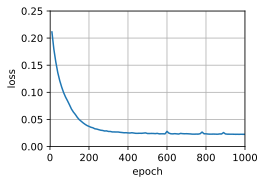

In [19]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.0
batch_size, num_steps = 64, 10
lr, num_epochs, ctx = 0.005, 1000, d2l.try_gpu()

src_vocab, tgt_vocab, train_iter = d2l.load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(
    len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(
    len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = d2l.EncoderDecoder(encoder, decoder)
train_s2s_ch8(model, train_iter, lr, num_epochs, ctx)

In [21]:
model.save_parameters("seq2seq_8_09_2019")

KeyboardInterrupt: 

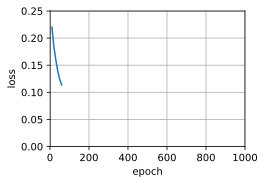

In [22]:
model.load_parameters("seq2seq_8_09_2019")
train_s2s_ch8(model, train_iter, lr, num_epochs, ctx)

## Predicting

Here we implement the simplest method, greedy search, to generate an output
sequence.
During predicting, we feed the same "&lt;bos&gt;" token to the decoder as training at time step 0. But the input token for a later time step is the predicted token from the previous time step.

![Sequence to sequence model predicting with greedy search](../img/seq2seq_predict.svg)

In [16]:
# Save to the d2l package.
def predict_s2s_ch8(model, src_sentence, src_vocab, tgt_vocab, num_steps, ctx):
    src_tokens = src_vocab[src_sentence.lower().split(' ')]
    enc_valid_length = nd.array([len(src_tokens)], ctx=ctx)
    src_tokens = d2l.trim_pad(src_tokens, num_steps, src_vocab.pad)
    enc_X = nd.array(src_tokens, ctx=ctx)
    # add the batch_size dimension.
    enc_outputs = model.encoder(enc_X.expand_dims(axis=0), enc_valid_length)
    dec_state = model.decoder.init_state(enc_outputs, enc_valid_length)
    dec_X = nd.array([tgt_vocab.bos], ctx=ctx).expand_dims(axis=0)
    predict_tokens = []
    for _ in range(num_steps):
        Y, dec_state = model.decoder(dec_X, dec_state)
        # The token with highest score is used as the next time step input.
        dec_X = Y.argmax(axis=2)
        py = dec_X.squeeze(axis=0).astype('int32').asscalar()
        if py == tgt_vocab.eos:
            break
        predict_tokens.append(py)
    return ' '.join(tgt_vocab.to_tokens(predict_tokens))

Try several examples:

In [20]:
for sentence in ['Go .', 'Wow !', "I'm OK .", 'I won !','I leave today']:
    print(sentence + ' => ' + predict_s2s_ch8(
        model, sentence, src_vocab, tgt_vocab, num_steps, ctx))

Go . => va !
Wow ! => <unk> !
I'm OK . => je vais bien .
I won ! => j'ai gagné !
I leave today => je l'ai emporté .


## Summary